In [1]:
!nvidia-smi

Sat Jan 22 20:02:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gdown==4.2.0

# clone the repository
!git clone https://github.com/NVlabs/stylegan2-ada.git
%cd stylegan2-ada

# make the pretrained directory to put the model checkpoint in
!mkdir pretrained
%cd pretrained

# download pretrained model
!wget -O pretrained_ada_ffhq_1024.pkl http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl
%cd ../

# download code files for face alignment
!wget https://raw.github.com/woctezuma/stylegan2/tiled-projector/align_images.py
!mkdir ffhq_dataset
%cd ffhq_dataset
!wget https://raw.github.com/woctezuma/stylegan2/tiled-projector/ffhq_dataset/face_alignment.py
!wget https://raw.github.com/woctezuma/stylegan2/tiled-projector/ffhq_dataset/landmarks_detector.py
%cd ../

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14273 sha256=21aaded568e9e751e1f92936e0177f0c3f13374952141e675598f3f8b9c178ef
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4
Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 74 (delta 0), reused 1 (delta 0), pack-reused 71
Unpacking objects: 100% (74/74), done.
/content/stylegan2-ada
/content/stylegan2-ada/pretrained
--2022-01-22 20:02:20--  http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving d36zk2

In [3]:
# downloading resources for boundary classification
!mkdir classification_data/
%cd classification_data/

!gdown --id 1eXWwf4H-H2mnwnyn5T2GuScwgz-5bJ3O
!gdown --id 1JAfUcXUU_5QaQf08oV5GrnAPPLx9ctxc
!gdown --id 13tlgLfVBYkqypTAdU3FpR8lPpDKeBV9b
!gdown --id 17tghEeA7ss4fKh_VyL_NKDZ5CYfWl1Ns
%cd ../

/content/stylegan2-ada/classification_data
Downloading...
From: https://drive.google.com/uc?id=1eXWwf4H-H2mnwnyn5T2GuScwgz-5bJ3O
To: /content/stylegan2-ada/classification_data/artifact_latents_3_positive_updated.npy
100% 64.3M/64.3M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JAfUcXUU_5QaQf08oV5GrnAPPLx9ctxc
To: /content/stylegan2-ada/classification_data/artifact_latents_3_negative_updated.npy
100% 73.7M/73.7M [00:00<00:00, 187MB/s]
Downloading...
From: https://drive.google.com/uc?id=13tlgLfVBYkqypTAdU3FpR8lPpDKeBV9b
To: /content/stylegan2-ada/classification_data/artifact_latents_3_positive.npy
100% 68.3M/68.3M [00:00<00:00, 95.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=17tghEeA7ss4fKh_VyL_NKDZ5CYfWl1Ns
To: /content/stylegan2-ada/classification_data/artifact_latents_3_negative.npy
100% 73.7M/73.7M [00:01<00:00, 42.4MB/s]
/content/stylegan2-ada


In [4]:
import numpy as np

# loading the latent vectors
pos_latents = np.load('classification_data/artifact_latents_3_positive_updated.npy')
neg_latents = np.load('classification_data/artifact_latents_3_negative_updated.npy')

# assigining labels for classification
# 1 for image with anomaly and 0 for good image
pos_labels = np.ones(len(pos_latents))
neg_labels = np.zeros(len(neg_latents))

dlatent_data = np.vstack((pos_latents, neg_latents)) 
all_labels = np.hstack((pos_labels, neg_labels))

dlatent_data = dlatent_data.reshape((-1, 18*512))

print('Positive images = {}'.format(len(pos_latents)))
print('Negative images = {}'.format(len(neg_latents)))

Positive images = 1743
Negative images = 2000


In [5]:
## Train a simple classifier on the latent vectors

from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
# from sklearn.metrics import accuracy_score

clf = LogisticRegression(class_weight=None, max_iter=10000)
clf.fit(dlatent_data.reshape((-1, 18*512)), all_labels)
attribute_direction = clf.coef_.reshape((18, 512))
print(clf.score(dlatent_data, all_labels))

0.8640128239380176


In [6]:
## saving and loading of the classifier

import joblib 
import pickle

filename = 'classification_data/artifacts_model_face_3_20k.joblib'
pickle.dump(clf, open(filename, 'wb'))
joblib.dump(clf, filename)

# clf = joblib.load(filename)

['classification_data/artifacts_model_face_3_20k.joblib']

In [7]:
%tensorflow_version 1.x

import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import matplotlib.pyplot as plt
import random

global Gs
global noise_vars
dnnlib.tflib.init_tf()

def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img#.resize((256, 256))

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]
    
    imgs = []
    for dlatent in dlatents: 
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        # ax[i].imshow(generate_image(new_latent_vector))
        new_latent_vector = np.expand_dims(new_latent_vector,0)
        new_latent_vector = np.expand_dims(new_latent_vector,0)
        ax[i].imshow(generate_images_in_w_space(new_latent_vector, 0)[0])
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()


TensorFlow 1.x selected.


In [8]:
# loading model for inference
network_pkl = 'pretrained/pretrained_ada_ffhq_1024.pkl' 

with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]


Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.


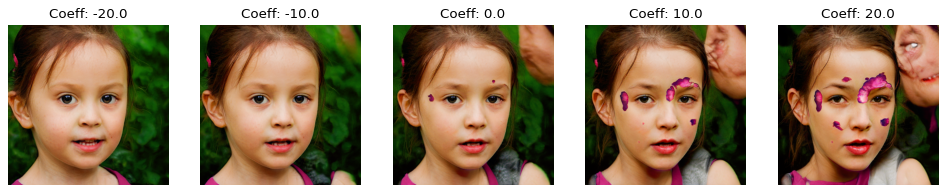

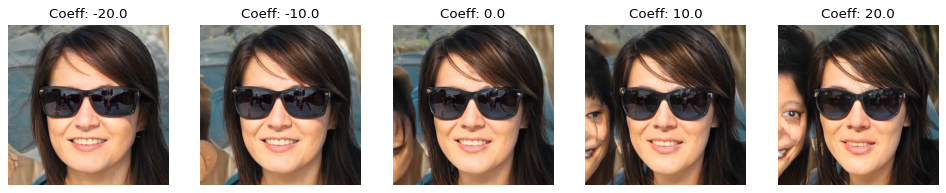

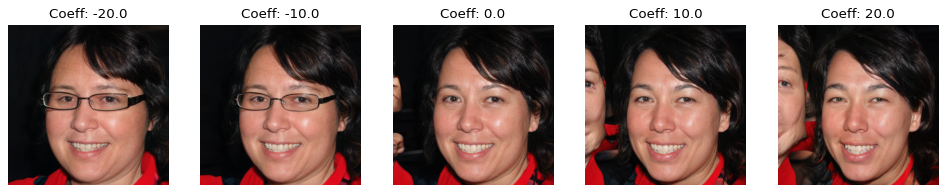

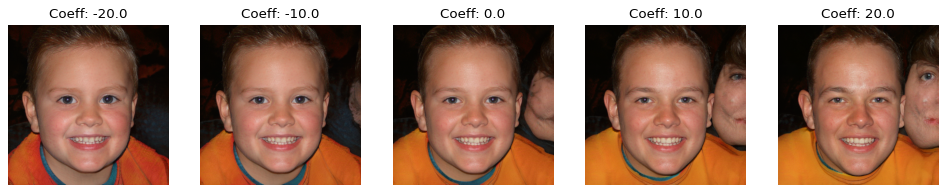

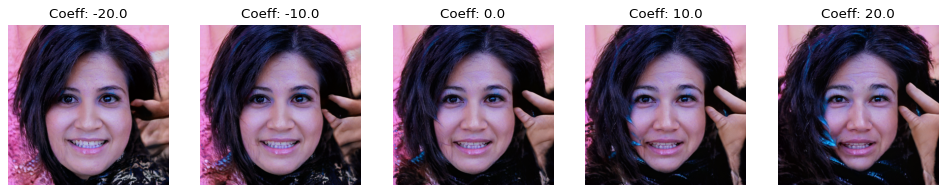

In [9]:
# Set the number of images you want to display
num_imgs = 5

dlatent_random = np.array(random.sample(list(pos_latents), num_imgs))
for i in range(num_imgs):
    move_and_show(dlatent_random.reshape((-1, 18, 512))[i], attribute_direction, [-20, -10, 0, 10, 20])

In [10]:
def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

def convertZtoW(latent, truncation_psi, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def gen_one_img(trunc_idx = 0.7):
    seeds = np.random.randint((2**32 - 1), size=1)
    zs = generate_zs_from_seeds(seeds)
    dls = []
    for z in zs:
        dls.append(convertZtoW(z ,truncation_psi=trunc_idx))

    gen_images = generate_images_in_w_space(dls, trunc_idx)
    return gen_images[0], dls[0]

def correct_one_img(latent_vector, direction, coeff):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
    # ax[i].imshow(generate_image(new_latent_vector))
    new_latent_vector = np.expand_dims(new_latent_vector,0)
    return generate_images_in_w_space(new_latent_vector, 0.1)[0]#, new_latent_vector

In [21]:
## Check performance on test images

# set image correction intensity. More negative value means more correction 
correction_intensity = -10
trunc_idx = 0.3
img, latent = gen_one_img(trunc_idx)

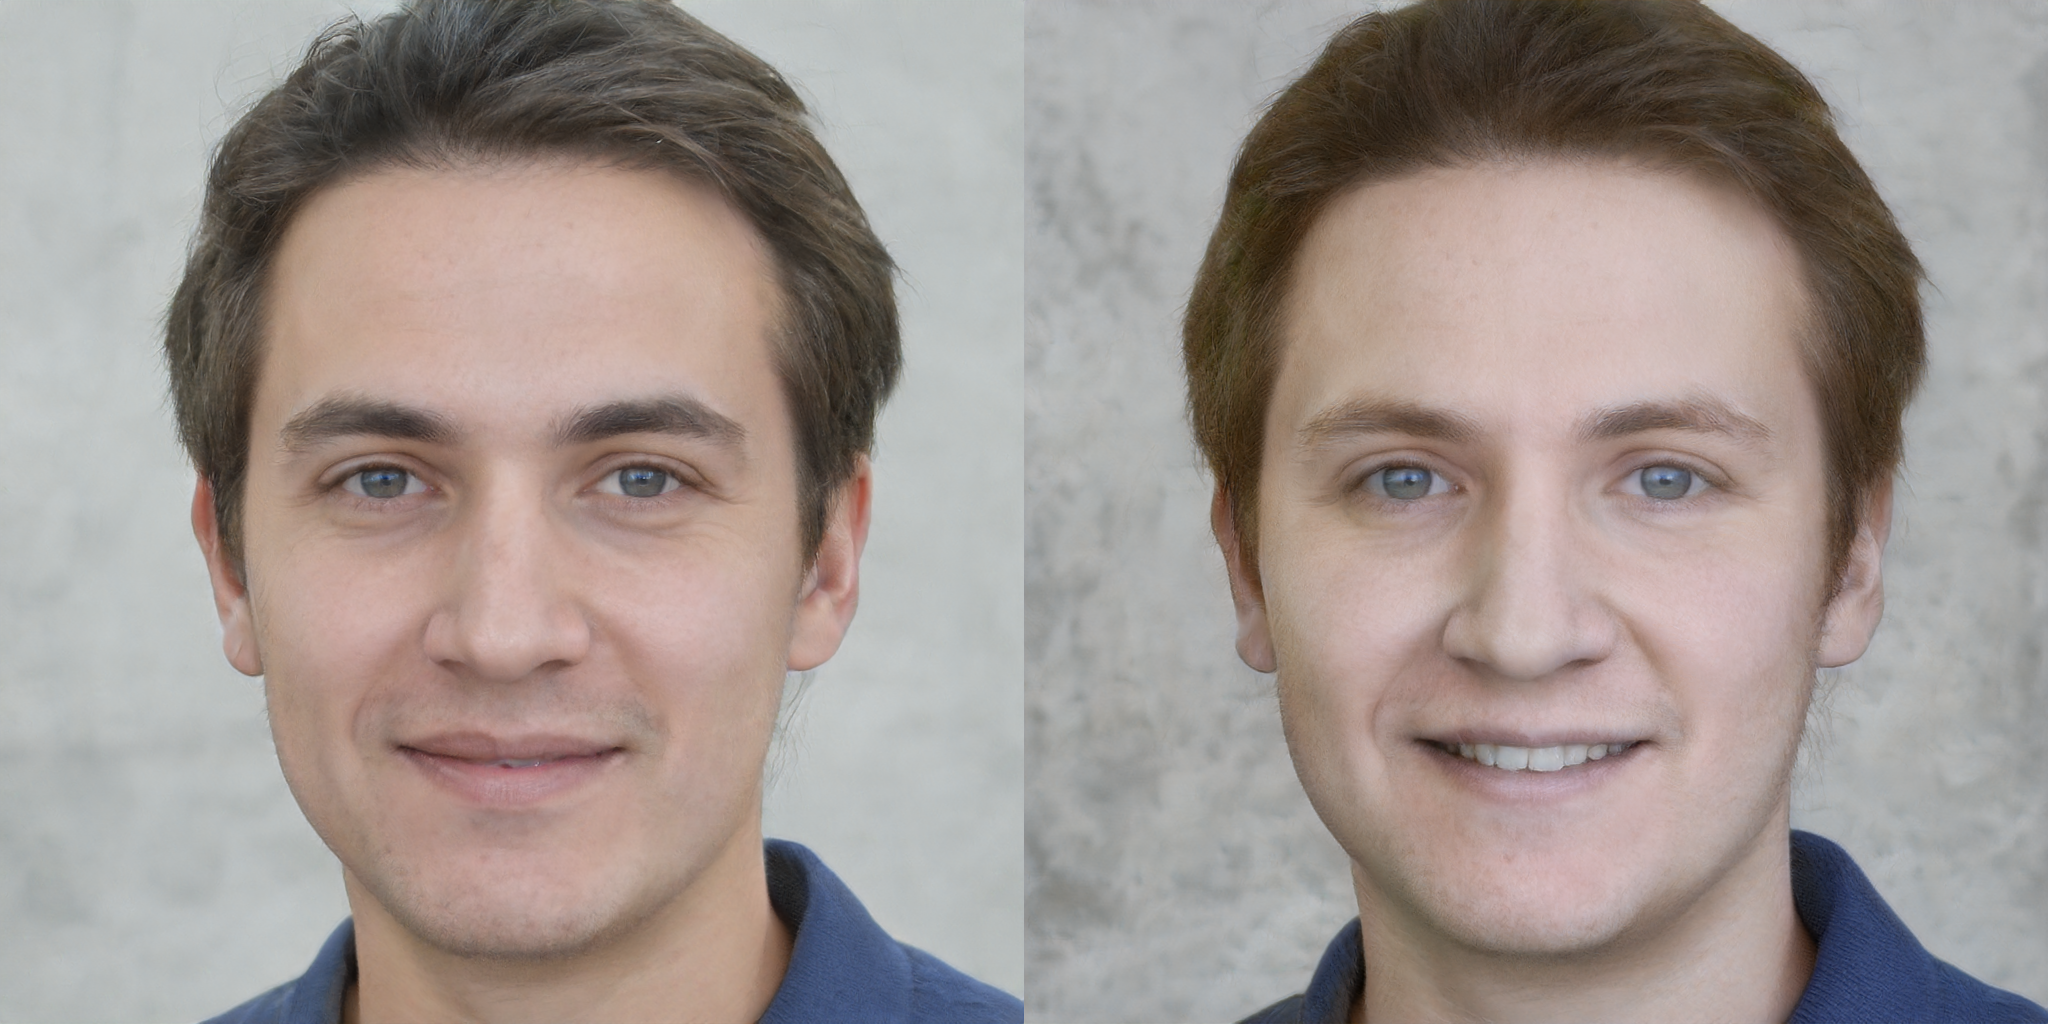

In [22]:
corrected_img = correct_one_img(latent, attribute_direction, correction_intensity)
PIL.Image.fromarray(np.hstack((img,corrected_img)))

In [13]:
# download the test images folder
!gdown --folder 'https://drive.google.com/drive/folders/1duHMAnLOwx_En-2CsjHCs0nJwGTyHwPM?usp=sharing'

Retrieving folder list
Processing file 12l1PsK27XN4ja-Vjlcr9ebYRPpuEKmQS subject1_tc3.jpg
Processing file 1o61TJf_IZ0AO3MtpipITYusb-5lS-9Lp subject1_tc4.jpg
Processing file 1N9yI-knyiR23Z2QiBDpn3Q234ahm7pns subject1_tc5.jpg
Processing file 1_4JpOQB32RgS9cLSktqlQRmVKbRAQGsr subject1_tc6.jpg
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=12l1PsK27XN4ja-Vjlcr9ebYRPpuEKmQS
To: /content/stylegan2-ada/test_cases/subject1_tc3.jpg
100% 700k/700k [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o61TJf_IZ0AO3MtpipITYusb-5lS-9Lp
To: /content/stylegan2-ada/test_cases/subject1_tc4.jpg
100% 641k/641k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N9yI-knyiR23Z2QiBDpn3Q234ahm7pns
To: /content/stylegan2-ada/test_cases/subject1_tc5.jpg
100% 338k/338k [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_4JpOQB32RgS9cLSkt

In [14]:
# align images like ffhq for better estimation
!python3 align_images.py test_cases/ aligned_images/

Using TensorFlow backend.
64045056/64040097 [==============================] - 2s 0us/step


In [ ]:
# project images to get latent vector
!python3 projector.py --outdir='out_projections' --target='aligned_images/subject1_tc6_01.png' --network='pretrained/pretrained_ada_ffhq_1024.pkl'
# !python3 projector.py --outdir='out_projections_unaligned' --target='test_cases/subject1_tc4.jpg' --network='pretrained/pretrained_ada_ffhq_1024.pkl'

Loading networks from "pretrained/pretrained_ada_ffhq_1024.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.
Projector: Computing W midpoint and stddev using 10000 samples...
Projector: std = 10.0058
Projector: Setting up noise inputs...
Projector: Building image output graph...
Projector: Building loss graph...
Projector: Building noise regularization graph...
Projector: Setting up optimizer...
Projector: Preparing target images...
Projector: Initializing optimization state...
 88% 877/1000 [04:17<00:35,  3.51it/s, dist=0.2725, loss=0.27]

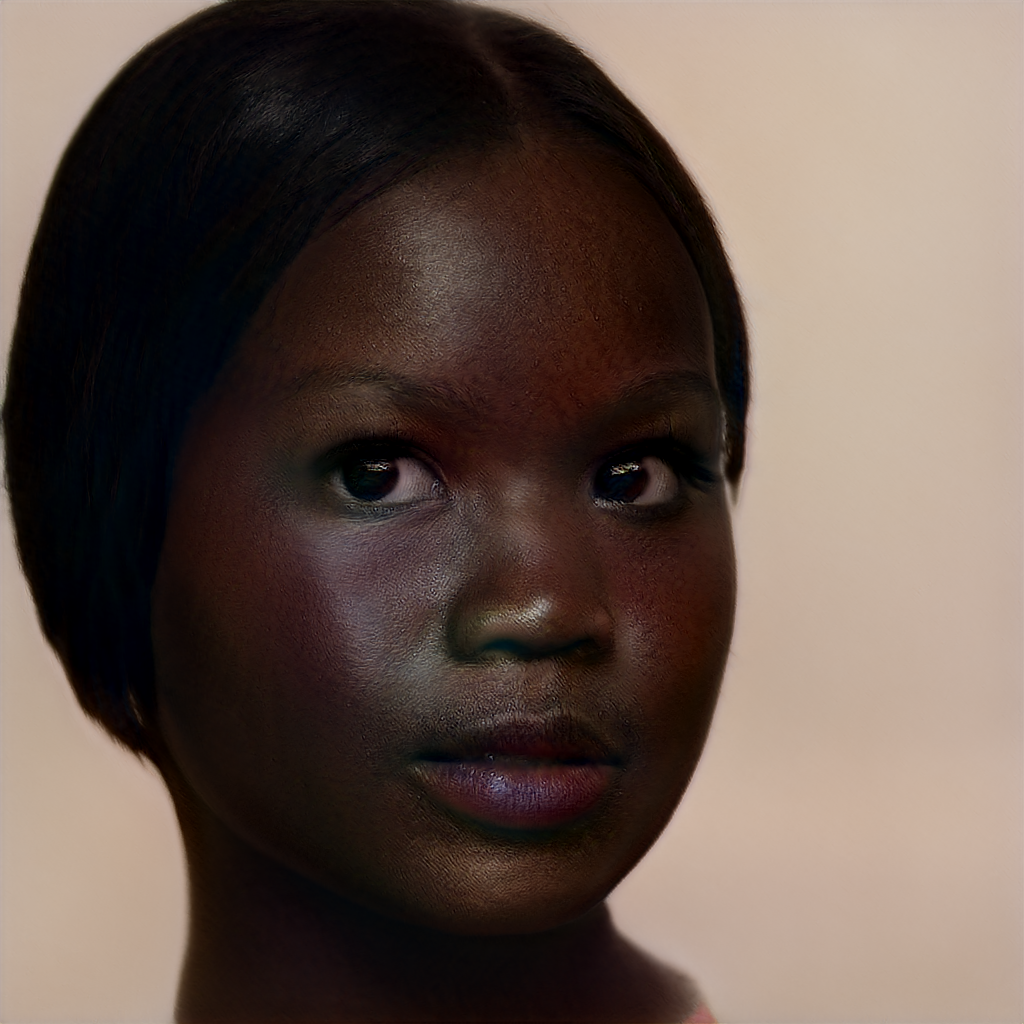

In [31]:
## Prediction on custom image
correction_intensity = -20

path_latent = 'out_projections/dlatents.npz'
latent = np.load(path_latent)['dlatents']
img = generate_images_in_w_space(np.expand_dims(latent,0), trunc_idx)[0]
corrected_img = correct_one_img(latent, attribute_direction, correction_intensity)
# PIL.Image.fromarray(np.hstack((img,corrected_img)))
corrected_img